In [1]:
import numpy as np
from laughter_prediction.predictors import RnnPredictor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

In [2]:
def load_X_y_fbank():
    X = np.load("X_fbank.npy")
    y = np.load("y_fbank.npy")
    return X.astype(np.float32), y.astype(np.float32)


def load_X_y_mfcc():
    X = np.load("X_mfcc.npy")
    y = np.load("y_mfcc.npy")
    return X.astype(np.float32), y.astype(np.float32)


In [3]:
def train():
    n_for_test = 200
    n_for_valid = 200
    X_mfcc, y = load_X_y_mfcc()
    X_fbank, y = load_X_y_fbank()
    
    X_mfcc, X_mfcc_test = X_mfcc[n_for_test:], X_mfcc[:n_for_test]
    X_fbank, X_fbank_test = X_fbank[n_for_test:], X_fbank[:n_for_test]
    y, y_test = y[n_for_test:], y[:n_for_test]
    
    X_mfcc, X_mfcc_valid = X_mfcc[n_for_valid:], X_mfcc[:n_for_valid]
    X_fbank, X_fbank_valid = X_fbank[n_for_valid:], X_fbank[:n_for_valid]
    y, y_valid = y[n_for_valid:], y[:n_for_valid]

    good_idxs = np.where(y.sum(axis=1) >= 10)[0]
    
    X_mfcc = np.vstack(
        (X_mfcc, X_mfcc[good_idxs], X_mfcc[good_idxs], X_mfcc[good_idxs], X_mfcc[good_idxs], X_mfcc[good_idxs]))
    X_fbank = np.vstack(
        (X_fbank, X_fbank[good_idxs], X_fbank[good_idxs], X_fbank[good_idxs], X_fbank[good_idxs], X_fbank[good_idxs]))
    y = np.vstack((y, y[good_idxs], y[good_idxs], y[good_idxs], y[good_idxs], y[good_idxs]))

    predictor = RnnPredictor("rnn_model")
    predictor.train(X_mfcc, X_fbank, y,
                    X_mfcc_test, X_fbank_test, y_test,
                    batch_size=8, epoches=0, hidden_size=10)
    
    return predictor, X_mfcc_valid, X_fbank_valid, y_valid

In [4]:
print("pretrained model", end=" ")
predictor, X_mfcc_valid, X_fbank_valid, y_valid = train()

pretrained model loading..


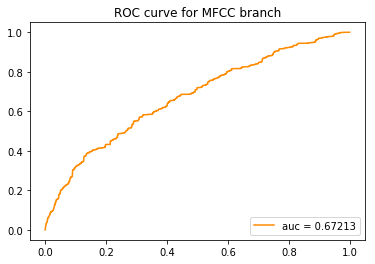

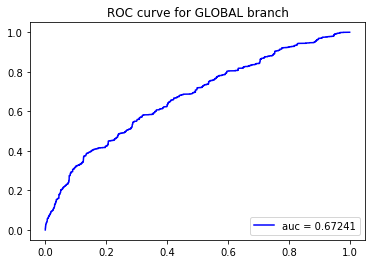

In [71]:
y_mfcc, y_global = predictor.predict_proba(X_mfcc_valid, X_fbank_valid)

y_mfcc_, y_global_, y_valid_ = y_mfcc.ravel(), y_global.ravel(), y_valid.ravel().astype(int)

fpr_mfcc, tpr_mfcc, _ = roc_curve(y_valid_, y_mfcc_)
fpr_global, tpr_global, _ = roc_curve(y_valid_, y_global_)
roc_auc_mfcc = auc(fpr_mfcc, tpr_mfcc)
roc_auc_global = auc(fpr_global, tpr_global)

plt.plot(fpr_mfcc, tpr_mfcc, color='darkorange', label=f'auc = {roc_auc_mfcc:.5}')
plt.title("ROC curve for MFCC branch")
plt.legend(loc="lower right")
plt.show()
plt.plot(fpr_global, tpr_global, color='blue', label=f'auc = {roc_auc_global:.5}')
plt.title("ROC curve for GLOBAL branch")
plt.legend(loc="lower right")


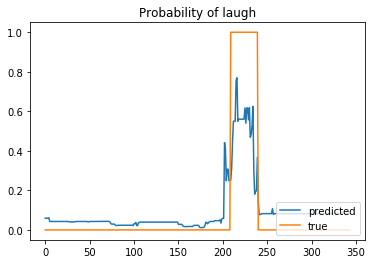

In [70]:
plt.title("Probability of laugh")
plt.plot(np.arange(y_valid.shape[1]), y_global[-41], label="predicted")
plt.plot(np.arange(y_valid.shape[1]), y_valid[-41], label="true")
plt.legend(loc="lower right")
